# MMMI Oversight Script


POPULATION MODEL

**TODO**: Option for rolling macro updates

**TODO**: Distribution of agent wealth. (1st, second, third moment)

**TODO**: Fix steady state computation

**TODO**: track and display agent histories of consumption and earnings as well as dividend payouts.

OTHER


**TODO**: Reduce NL logging/warning in the notebook.

**TODO**: `requirements.txt`

**TODO**: Begin automated tests

**TODO**: How do deal with varying 'AdjustPrbs' in quarterly and daily solution steps.



In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
from HARK.Calibration.Income.IncomeTools import (
     sabelhaus_song_var_profile,
)
import hark_portfolio_agents as hpa
import itertools
import logging
import math
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

## Portfolio Consumption Model

The AttentionSimulation uses the Portfolio Consumption model from HARK.
The agent's resources unfold according to the following transition equations.

Variable | Equation | Operation | Stage | Utility
-- | -- | -- | -- | --
$\eta$ | ~Dist | Shock | c | --
$\theta$ | ~Dist | Shock | c | --
$\psi$ | ~Dist | Shock | c | --
$\hat{R}$ | $$\hat{R} = \alpha * R + (1 - \alpha) * R$$ | Update | c | --
b | $b_{t} = a_{t-1} \hat{R}$ | Update | c | --
p | $p_{t}=p_{t-1}\psi_{t}$ | Update | c | --
y | $y_{t} = p_{t}\theta _{t}$ | Update | c | --
m | $m_{t} = b_{t} + y_{t}$ | Update | c | --
c | c | Control | c | U(c)
a | $a_{t} = m_{t} - c_{t}$ | Update | portshare | --
$\alpha$ | $\alpha$ | Control | portshare | 0


## Initialize the Simulation

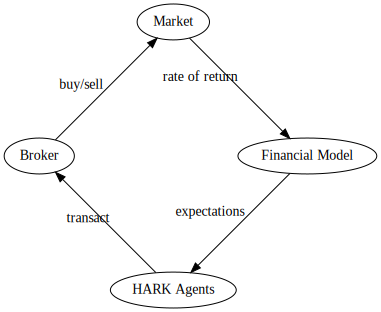

In [2]:
import graphviz as gv

dot = gv.Digraph(engine='circo')

dot.node('A', 'HARK Agents')
dot.node('B', 'Broker')
dot.node('M', 'Market')
dot.node('F', 'Financial Model')

dot.edge('A', 'B', label="transact")
dot.edge('B', 'M', label="buy/sell")
dot.edge('M', 'F', label="rate of return")
dot.edge('F', 'A', label="expectations")

dot

The AttentionSimulation class operates the "oversight code" with respect to four other simulation elements.

* HARK Agents - The consumers that earn, consume, and invest in the risky asset. When they have new targets for allocating their assets, they transact with the broker to buy or sell assets. They do this at the current 'market price'.
* Broker - Aggregates the consumer 
* Market - The PyNetLogo model of the Market, which takes the aggregate consumer demand and returns a rate of return.
* Financial Model - Computes the expectations of the risky asset from the rates of return history.

### Initialize agents to start

This is to set up the agent parameters and quantities used in the simulation.

`CRRA` refers to the `\rho` parameter in the constant relative risk aversion utility function used by the agents. Utility is over units of resources consumed.

`aNrmInitStd` is normalized initial market assets, standard deviation. The agents' starting wealth is drawn from a lognormal distribution with this standard deviation.

`pLvlInitMean` and `pLvlInitStd` are the mean and standard deviation of the initial level of permanent income of the agents.

In [3]:
import math

dist_params = {
    'CRRA' : {'bot' : 2, 'top' : 10, 'n' : 3}, # Chosen for "interesting" results
    'DiscFac' : {'bot' : 0.936, 'top' : 0.978, 'n' : 3} # from CSTW "MPC" results
}

# Get empirical data from Sabelhaus and Song
ssvp = sabelhaus_song_var_profile()

# Assume all the agents are 40 for now.
# We will need to make more coherent assumptions about the timing and age of the population later.
# Scaling from annual to quarterly
idx_40 = ssvp['Age'].index(40)

### parameters shared by all agents
agent_parameters = {
    'aNrmInitStd' : 0.0,
    'LivPrb' : [0.98 ** 0.25],
    'PermGroFac': [1.01 ** 0.25],
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0,
    'Rfree' : 1.0,
    'TranShkStd' : [ssvp['TranShkStd'][idx_40] / 2],  # Adjust non-multiplicative shock to quarterly
    'PermShkStd' : [ssvp['PermShkStd'][idx_40] ** 0.25]
}

In [4]:
class AgentPopulation():
    """
    A class encapsulating the population of 'macroeconomy' agents.
    
    These agents will be initialized with a distribution of parameters,
    such as risk aversion and discount factor.
    
    Parameters
    ------------
    
    base_parameters: Dict
        A dictionary of parameters to be shared by all agents.
        These correspond to parameters of the HARK ConsPortfolioModel AgentType
    """
    agents = None
    base_parameters = None
    dist_params = None
    
    def __init__(self, base_parameters, dist_params, n_per_class):
        self.base_parameters = base_parameters
        self.dist_params = dist_params
        self.agents = hpa.create_distributed_agents(self.base_parameters, dist_params, n_per_class)
        
    def init_simulation(self):
        """
        Ready the agents for the simulation.
        """
        hpa.init_simulations(self.agents)
        
    def data(self):
        """
        Output of relevant data with results of the simulation.
        """
    
        # abstract this over dist_params
        levels = [{
            'CRRA' : agent.parameters['CRRA'],
            'DiscFac' : agent.parameters['DiscFac'],
            'aLvl' : agent.state_now['aLvl']
            } for agent in attsim.agents]

        batched_records = [[
            {'CRRA' : elem['CRRA'], 'DiscFac' : elem['DiscFac'], 'aLvl' : aLvl}
            for aLvl in elem['aLvl']
            ] for elem in levels]

        records = [record for records in batched_records for record in records]

        wealth_df = pd.DataFrame.from_records(records)
        
        return wealth_df

## Get agent risky allocations

Use this stock price to determine the initial number of shares of the risky asset held by each
agent:
 - $RAS_{i0} = (HEC_{i0}.RAW)/ RAP_0$
 
 where RAW is Risky Asset Wealth, amount of resources allocated to the risky asset.
 
 RAS is Risky Asset Shares, number of shares the agent has.

In [5]:
class AttentionSimulation():
    """
    Encapsulates the "Oversight Code" functions of the experiment.
    Connects the Agent population model with a Broker, a Market simulation,
    and a FinanceModel of expected share prices.
    
    Parameters
    ----------
    
    agents: [HARK.AgentType]
    
    fm: hpa.FinanceModel
    
    q: int - number of quarters
    
    r: int - runs per quarter
    
    a: float - attention rate (between 0 and 1)
    
    """
    agents = None
    
    broker = None
    
    dollars_per_hark_money_unit = 1500
    
    # Number of days in a quarter / An empirical value based on trading calendars.
    days_per_quarter = 60
    
    # A FinanceModel
    fm = None
    
    # Simulation parameters
    quarters_per_simulation = None # Number of quarters to run total
    
    # Number of market runs to do per quarter
    # Valid values: 1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 30, 60...
    runs_per_quarter = None
    
    # For John's prefered condition: days per quarter = runs per quarter
    # Best if an integer.
    days_per_run = None
    
    ## upping this to make more agents engaged in trade
    attention_rate = None
    
    # for tracking history of the simulation
    history = {}
    
    # dividend_ror -> on financial model
    # dividend_std -> on financial model; on MarketPNL
    
    # sp500_ror = 0.000628 -> on financial model; on MarketPNL
    # sp500_std = 0.011988 -> on financial model; on MarketPNL
    
    def __init__(self, pop, fm, q = 1, r = None, a = None):
        
        self.agents = pop.agents
        self.fm = fm
        
        self.quarters_per_simulation = q
        
        if r is not None:
            self.runs_per_quarter = r
        else:
            self.runs_per_quarter = self.days_per_quarter
        self.days_per_run = self.days_per_quarter / self.runs_per_quarter
        
        # TODO: Make this more variable.
        if a is not None:
            self.attention_rate = a
        else:
            self.attention_rate = 1 / self.runs_per_quarter 
        
        
        # Create the Market wrapper
        market = hpa.MarketPNL()
        self.broker = hpa.Broker(market)

        self.history = {}
        self.history['buy_sell'] = []
        self.history['owned_shares'] = []
        self.history['total_assets'] = []
    
    def attend(self, agent):
        """
        Cause the agent to attend to the financial model.
    
        This will update their expectations of the risky asset.
        They will then adjust their owned risky asset shares to meet their
        target.
    
        Return the delta of risky asset shares ordered through the brokers.
        
        NOTE: This MUTATES the agents with their new target share amounts.
        """
        # Note: this mutates the underlying agent
        agent.assign_parameters(**self.fm.risky_expectations())
            
        d_shares = self.compute_share_demand(agent)
            
        delta_shares = d_shares - agent.shares
            
        # NOTE: This mutates the agent
        agent.shares = d_shares
    
        return delta_shares
    
    def compute_share_demand(self, agent):
        """
        Computes the number of shares an agent _wants_ to own.
    
        This involves:
          - Computing a solution function based on their
            expectations and personal properties
          - Using the solution and the agent's current normalized
            assets to compute a share number
        """
        agent.assign_parameters(AdjustPrb = 1.0)
        agent.solve()
        asset_normalized = agent.state_now['aNrm']

        # ShareFunc takes normalized market assets as argument
        risky_share = agent.solution[0].ShareFuncAdj(
            asset_normalized
        )
    
        # denormalize the risky share. See https://github.com/econ-ark/HARK/issues/986
        risky_asset_wealth = risky_share \
                            * asset_normalized \
                            * agent.state_now['pLvl'] \
                            * self.dollars_per_hark_money_unit 
        
        shares = risky_asset_wealth / self.fm.rap()
    
        if (np.isnan(shares)).any():
            print("ERROR: Agent has nan shares")
    
        return shares
    
    def data(self):
        """
        Returns a Pandas DataFrame of the data from the simulation run.
        """
        data = pd.DataFrame.from_dict({
            't' : range(len(self.fm.prices)),
            'prices' : self.fm.prices,
            'buy' : [None] + [bs[0] for bs in self.broker.buy_sell_history],
            'sell' : [None]  + [bs[1] for bs in self.broker.buy_sell_history],
            'owned' : self.history['owned_shares'],
            'total_assets' : self.history['total_assets'],
            'ror' : [None] + self.fm.ror_list,
            'expected_ror' : self.fm.expected_ror_list,
            'expected_std' : self.fm.expected_std_list,
        })

        return data

    
    def macro_update(self, agent):
        """
        Input: an agent, a FinancialModel, and a Broker
    
        Simulates one "macro" period for the agent (quarterly by assumption).
        For the purposes of the simulation, award the agent dividend income
        but not capital gains on the risky asset.
        """
    
        #agent.assign_parameters(AdjustPrb = 0.0)
        agent.solve()
        
        ## For risky asset gains in the simulated quarter,
        ## use only the dividend.
        true_risky_expectations = {
            "RiskyAvg" : agent.parameters['RiskyAvg'],
            "RiskyStd" : agent.parameters['RiskyStd']   
        }
        
        dividend_risky_params = {
            "RiskyAvg" : 1 + self.fm.dividend_ror,
            "RiskyStd" : self.fm.dividend_std
        }
        
        agent.assign_parameters(**dividend_risky_params)
        
        agent.simulate(sim_periods=1)
        
        ## put back the expectations that include capital gains now
        agent.assign_parameters(**true_risky_expectations)
    
        # Selling off shares if necessary to
        # finance this period's consumption
        asset_level_in_shares = agent.state_now['aLvl'] \
            * self.dollars_per_hark_money_unit / self.fm.rap()

        delta = asset_level_in_shares - agent.shares
        delta[delta > 0] = 0

        agent.shares = agent.shares + delta
        self.broker.transact(delta)

    def report(self):
        data = self.data()

        fig, ax = plt.subplots(
            4, 1,
            sharex='col',
            #sharey='col',
            figsize=(12,16),
        )

        ax[0].plot(data['total_assets'], alpha=0.5, label='total assets')
        ax[0].plot([p * o for (p,o) in zip(data['prices'], data['owned'])], alpha=0.5, label='owned share value')
        ax[0].plot([100 * o for (p,o) in zip(data['prices'], data['owned'])], alpha=0.5, label='owned share quantity * p_0')
        ax[0].legend()

        ax[1].plot(data['buy'], alpha=0.5, label='buy')
        ax[1].plot(data['sell'], alpha=0.5, label='sell')
        ax[1].legend()

        ax[2].plot(data['ror'], alpha=0.5, label='ror')
        ax[2].plot(data['expected_ror'], alpha=0.5, label='expected ror')
        ax[2].legend()

        ax[3].plot(data['prices'], alpha=0.5, label='prices')
        ax[3].legend()
    
        ax[0].set_title("Simulation History")
        ax[0].set_ylabel("Dollars")
        ax[1].set_xlabel("t")
        
        plt.show()

    def simulate(self):
        """
        Workhorse method that runs the simulation.
        """
        seeds = itertools.cycle([2,3,6,0,1,4,5])

        # Initialize share ownership for agents
        for agent in self.agents:
            agent.shares = self.compute_share_demand(agent)

        self.track()

        # Main loop
        for quarter in range(self.quarters_per_simulation):
            print(f"Q-{quarter}")
    
            for agent in self.agents:
                self.macro_update(agent)

            day = 0

            for run in range(self.runs_per_quarter):
                print(f"Q-{quarter}:R-{run}")
        
                # Set to a number for a fixed seed, or None to rotate
                seed = next(seeds)

                for agent in self.agents:
                    if random.random() < self.attention_rate:
                        self.broker.transact(self.attend(agent))

                buy_sell, ror = self.broker.trade(seed)
                print("ror: " + str(ror))
        
                new_run = True
        
                for new_day in range(int(self.days_per_run)):
                    if new_run:
                        new_run = False
                    else:
                        # sloppy
                        # problem is that this should really be nan, nan
                        # putting 0,0 here is a stopgap to make plotting code simpler
                        self.broker.buy_sell_history.append((0,0))
            
                    day = day + 1
                    print(f"Q-{quarter}:D-{day}")
        
                    self.update_agent_wealth_capital_gains(self.fm.rap(), ror)
        
                    self.track()

                    # combine these steps?
                    risky_asset_price = self.fm.add_ror(ror)
                    self.fm.calculate_risky_expectations()

    def track(self):
        """
        Tracks the current state of agent's total assets and owned shares
        """
        tal = sum(
                [agent.state_now['aLvl'].sum()
                 for agent
                 in self.agents]
                ) * self.dollars_per_hark_money_unit
        os = sum([sum(agent.shares) for agent in self.agents])

        self.history['owned_shares'].append(os)
        self.history['total_assets'].append(tal)
    
    
    def update_agent_wealth_capital_gains(self, old_share_price, ror):
        """
        For all agents,
        given the old share price
        and a rate of return
    
        update the agent's wealth level to adjust
        for the most recent round of capital gains.
        """

        new_share_price = old_share_price * (1 + ror)

        for agent in self.agents:
            old_raw = agent.shares * old_share_price
            new_raw = agent.shares * new_share_price
    
            delta_aNrm = (new_raw - old_raw) / \
                (self.dollars_per_hark_money_unit * agent.state_now['pLvl'])
    
            # update normalized market assets
            # if agent.state_now['aNrm'] < delta_aNrm:
            #     breakpoint()
        
            agent.state_now['aNrm'] = agent.state_now['aNrm'] + delta_aNrm
        
            if (agent.state_now['aNrm'] < 0).any():
                print(f"ERROR: Agent with CRRA {agent.parameters['CRRA']} has negative aNrm after capital gains update.")
                print("Setting normalize assets and shares to 0.")
                agent.state_now['aNrm'][(agent.state_now['aNrm'] < 0)] = 0.0
                ## TODO: This change in shares needs to be registered with the Broker.
                agent.shares[(agent.state_now['aNrm'] == 0)] = 0

            # update non-normalized market assets
            agent.state_now['aLvl'] = agent.state_now['aNrm']  * agent.state_now['pLvl']
            
    def ror_volatility(self):
        """
        Returns the volatility of the rate of return.
        Must be run after a simulation.
        """
        return self.data()['ror'].dropna().std()

### Activating agents

"At the beginning of each trading day $t + 1$, select a random group of HARK agents with replacement."

**TODO**: HARK AgentType classes represent multiple agents (as many as `AgentCount`). It is difficult to have the agents within the same AgentType act 'separately', though these agents will have _ex ante_ and _ex post_ heterogeneity of some variables. For the purpose of MMMI, we may need to scaffold the agent model to make it easier to have multiple independently acting agents.

"**First**, determine the expected return and standard deviation of the risky asset to be used for decision period $t + 1$."

See `calculate_risky_expectations()`.

"**Second**, using [these expectations] calculate the total number of shares of the risky asset that the selected agents want to buy and sell."

"**Third**, using [total buy and sell shares] as input to the Buy Broker and Sell Broker, run a day of NetLogo trading and determine the end of day price of the risky asset."

See `hpa.run_market`.

"**Fourth**, use the final price to calculate the amount of wealth each (all) HARK agent has allocated to the risky asset."

"Repeat each trading day until the end of the quarter. Then update the economic conditions for each HARK agent (e.g., permanent income level), and repeat [daily loop]."

Accounting functions.

## Run the main loop



In [6]:
pop = AgentPopulation(agent_parameters, dist_params, 60)

def run_simulation(i):
    # Initialize the financial model
    fm = hpa.FinanceModel()

    fm.calculate_risky_expectations()
    agent_parameters.update(fm.risky_expectations())

    # Initialize the population model
    pop.init_simulation()
    
    attsim = AttentionSimulation(pop, fm, q = 2, r = 2)
    attsim.simulate()
    
    return attsim

In [7]:
attsim = run_simulation(0)

config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
Q-0
Q-0:R-0


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (892, 0)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL892SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 

Elapsed (sys clock), run 2:  50.164740327000004
ror: 0.02799105073529412
Q-0:D-1
Q-0:D-2
Q-0:D-3
Q-0:D-4
Q-0:D-5
Q-0:D-6
Q-0:D-7
Q-0:D-8
Q-0:D-9
Q-0:D-10
Q-0:D-11
Q-0:D-12
Q-0:D-13
Q-0:D-14
Q-0:D-15
Q-0:D-16
Q-0:D-17
Q-0:D-18
Q-0:D-19
Q-0:D-20
Q-0:D-21
Q-0:D-22
Q-0:D-23
Q-0:D-24
Q-0:D-25
Q-0:D-26
Q-0:D-27
Q-0:D-28
Q-0:D-29
Q-0:D-30
Q-0:R-1


Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (79, 597)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL79SL597.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 3:  30.906348778999984
ror: -0.007267772794117647
Q-0:D-31
Q-0:D-32
Q-0:D-33
Q-0:D-34
Q-0:D-35
Q-0:D-36
Q-0:D-37
Q-0:D-38
Q-0:D-39
Q-0:D-40
Q-0:D-41
Q-0:D-42
Q-0:D-43
Q-0:D-44
Q-0:D-45
Q-0:D-46
Q-0:D-47
Q-0:D-48
Q-0:D-49
Q-0:D-50
Q-0:D-51
Q-0:D-52
Q-0:D-53
Q-0:D-54
Q-0:D-55
Q-0:D-56
Q-0:D-57
Q-0:D-58
Q-0:D-59
Q-0:D-60
Q-1
Q-1:R-0


Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (91, 638)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL91SL638.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 6:  24.480253707999964
ror: -0.02489718455882353
Q-1:D-1
Q-1:D-2
Q-1:D-3
Q-1:D-4
Q-1:D-5
Q-1:D-6
Q-1:D-7
Q-1:D-8
Q-1:D-9
Q-1:D-10
Q-1:D-11
Q-1:D-12
Q-1:D-13
Q-1:D-14
Q-1:D-15
Q-1:D-16
Q-1:D-17
Q-1:D-18
Q-1:D-19
Q-1:D-20
Q-1:D-21
Q-1:D-22
Q-1:D-23
Q-1:D-24
Q-1:D-25
Q-1:D-26
Q-1:D-27
Q-1:D-28
Q-1:D-29
Q-1:D-30
Q-1:R-1


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (668, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL668SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 0:  31.355404528000008
ror: 0.02358369779411765
Q-1:D-31
Q-1:D-32
Q-1:D-33
Q-1:D-34
Q-1:D-35
Q-1:D-36
Q-1:D-37
Q-1:D-38
Q-1:D-39
Q-1:D-40
Q-1:D-41
Q-1:D-42
Q-1:D-43
Q-1:D-44
Q-1:D-45
Q-1:D-46
Q-1:D-47
Q-1:D-48
Q-1:D-49
Q-1:D-50
Q-1:D-51
Q-1:D-52
Q-1:D-53
Q-1:D-54
Q-1:D-55
Q-1:D-56
Q-1:D-57
Q-1:D-58
Q-1:D-59
Q-1:D-60


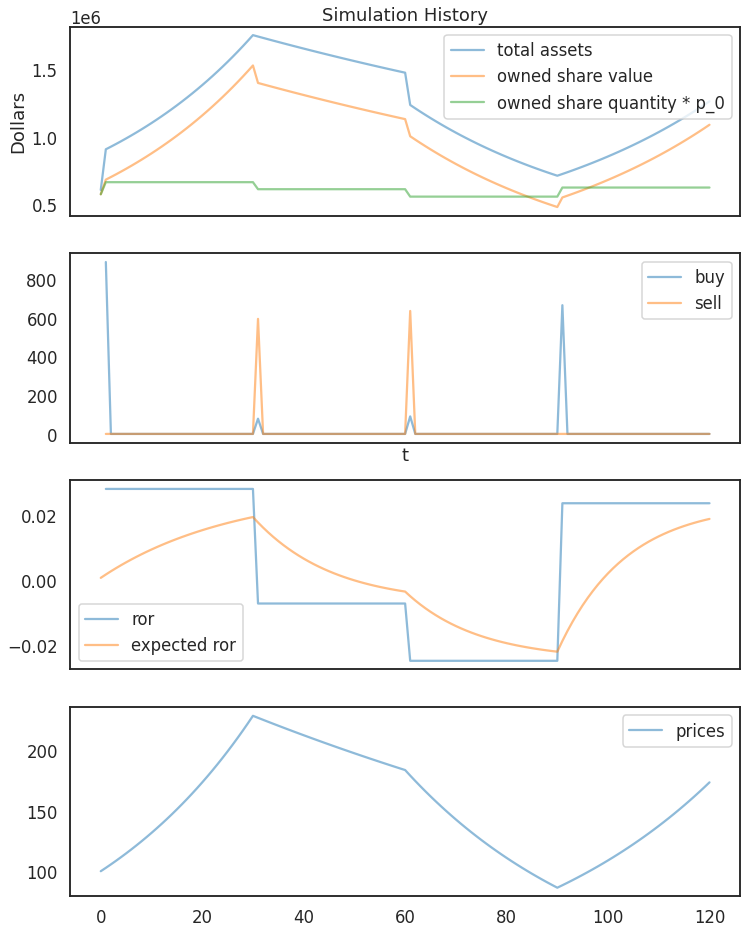

In [8]:
attsim.report()

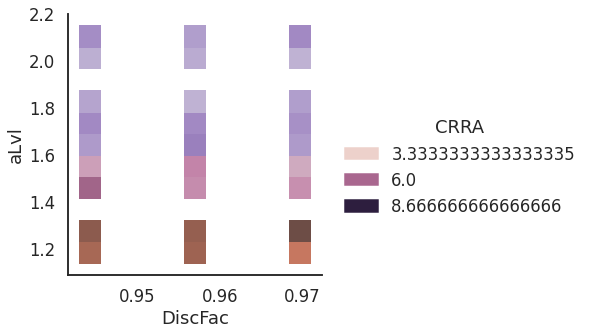

In [9]:
import seaborn as sns

sns.displot(pop.data(), x='DiscFac', y='aLvl', hue='CRRA')

In [10]:
pop.data().shape

(540, 3)

In [11]:
540 / 3

180.0

In [12]:
#import multiprocessing

#inputs = range(3)

#pool = multiprocessing.Pool()
#records = pool.map(run_simulation, inputs)
#pool.close()

In [13]:
#records

In [14]:
def report(data):
    fig, ax = plt.subplots(
        4, 1,
        sharex='col',
        #sharey='col',
        figsize=(12,16),
    )

    ax[0].plot(data['total_assets'], alpha=0.5, label='total assets')
    ax[0].plot([p * o for (p,o) in zip(data['prices'], data['owned'])], alpha=0.5, label='owned share value')
    ax[0].plot([100 * o for (p,o) in zip(data['prices'], data['owned'])], alpha=0.5, label='owned share quantity * p_0')
    ax[0].legend()

    ax[1].plot(data['buy'], alpha=0.5, label='buy')
    ax[1].plot(data['sell'], alpha=0.5, label='sell')
    ax[1].legend()

    ax[2].plot(data['ror'], alpha=0.5, label='ror')
    ax[2].plot(data['expected_ror'], alpha=0.5, label='expected ror')
    ax[2].legend()

    ax[3].plot(data['prices'], alpha=0.5, label='prices')
    ax[3].legend()
    
    ax[0].set_title("Simulation History")
    ax[0].set_ylabel("Dollars")
    ax[1].set_xlabel("t")
        
    plt.show()
    
#report(records[1])